In [1]:
# Data Visualization
import matplotlib.pyplot as plt

# Data Manipulation
import numpy as np
import pandas as pd

# Word2Vec Loading
import gensim.downloader as api
from gensim.models import KeyedVectors

# Trie for fast lookup
from datrie import BaseTrie
import string

# Dimensionality Reduction
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import os

In [2]:
# Import Google News 300 Word2Vec dataset
w2v_model: KeyedVectors = api.load('word2vec-google-news-300')

In [3]:
# Make a Trie for O(1) lookup of containment of words
t = BaseTrie(string.ascii_lowercase)

for x in w2v_model.index_to_key:
    t[x] = True

In [4]:
# Define a helper function to get the vector of a given word
def vec(str):
    return w2v_model.vectors[w2v_model.key_to_index[str]]

In [70]:
LEN_DATA = 50

list_dirnames = []
list_data = []
for subdir, dirs, files in os.walk('./BATS_3.0'):
    for file in files:
        if file.endswith('.txt'):
            list_dirnames.append(file)
            list_data.append(pd.read_csv(os.path.join(subdir, file), sep='\t', header=None))

# Add pair_id, which uniquely identifies each pair, and relation_id, which identifies the dataset
full_df = pd.concat([ df.assign(pair_id=range(LEN_DATA*i, LEN_DATA*(i+1)), relation_id=i) for i, df in enumerate(list_data) ])

# Remove all but the first result for the second element of each pair
full_df[1] = full_df[1].str.split('/', expand=True)[0]

# Remove all pairs where one of the words are not in the word2vec dataset
full_df = full_df[full_df[0].apply(t.__contains__) & full_df[1].apply(t.__contains__)]

In [14]:
word_pair_vecs = np.vstack(full_df[0].apply(vec)) - np.vstack(full_df[1].apply(vec))

In [16]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_reduce', PCA(n_components=2, random_state=42))
])

transform = pipe.fit_transform(word_pair_vecs)

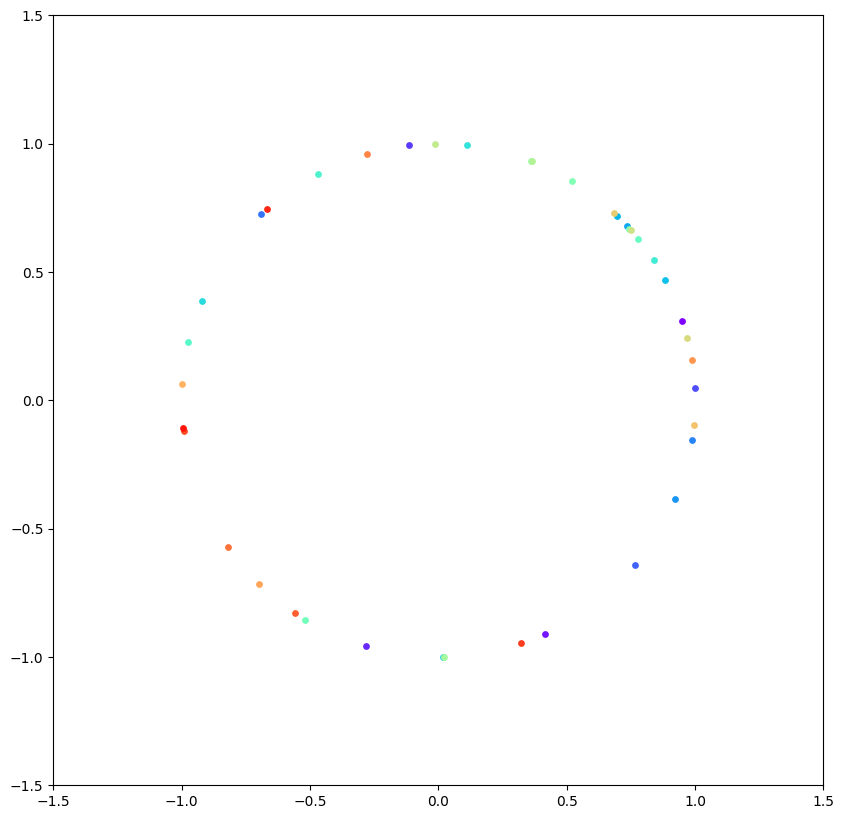

In [106]:
relations = full_df['relation_id'].unique()

fig, ax = plt.subplots(figsize=(10, 10))

names = pd.Series(list_dirnames).str.extract(r'\[(.*)\]')[0]

angles = []

for i, r in enumerate(relations):
    mean = transform[full_df['relation_id'] == r].mean(axis=0)
    normal = mean/np.linalg.norm(mean)

    angle = np.arctan2(*normal)
    angles.append(angle)

    color = plt.cm.rainbow(i/len(relations))
    plt.scatter(normal[0], normal[1], color=color, s=15)

# plt.legend()
plt.xlim((-1.5, 1.5))
plt.ylim((-1.5, 1.5))
ax.set_aspect('equal');

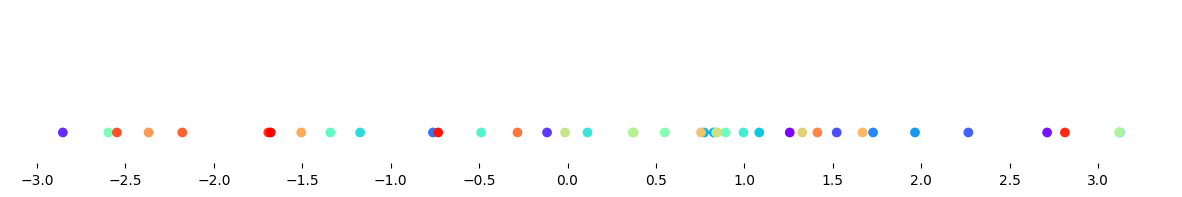

In [134]:
fig, ax = plt.subplots(figsize=(15, 2))

plt.scatter(angles, np.zeros_like(angles), c=np.linspace(0, 1, 40), cmap=plt.cm.rainbow)
plt.yticks([])
plt.ylim((-0.5, 2))
plt.xticks(np.linspace(-3, 3, 13))
plt.box(False)